# **Architecture**

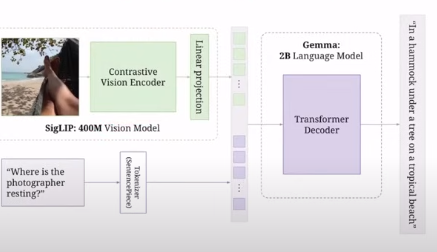

In [2]:
!pip install fire

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=0bacb2288e4328833016b9d02c230d50307cb3af521a505ba2e953586313b7e5
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [35]:
from typing import Dict, List, Optional, Union, Tuple, Iterable
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import math
import numpy as np
from PIL import Image
import fire
from transformers import AutoTokenizer
import json
import glob
from safetensors import safe_open
import os

#**SiglipVisionConfig**

In [4]:
class SiglipVisionConfig:

    def __init__(
        self,
        hidden_size=768,
        intermediate_size=3072,
        num_hidden_layers=12,
        num_attention_heads=12,
        num_channels=3,
        image_size=224,
        patch_size=16,
        layer_norm_eps=1e-6,
        attention_dropout=0.0,
        num_image_tokens: int = None,
        **kwargs
    ):
        super().__init__()

        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.num_channels = num_channels
        self.patch_size = patch_size
        self.image_size = image_size
        self.attention_dropout = attention_dropout
        self.layer_norm_eps = layer_norm_eps
        self.num_image_tokens = num_image_tokens

# **1.SigLip**

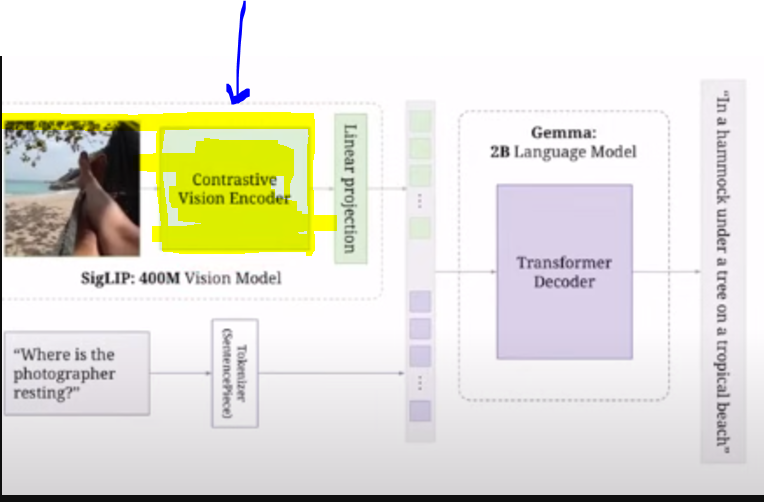

In [5]:
class SiglipVisionModel(nn.Module):

    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.vision_model = SiglipVisionTransformer(config)

    def forward(self, pixel_values) -> Tuple:
        # [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        return self.vision_model(pixel_values=pixel_values)

**1.1 SiglipVisionTransformer**

In [6]:
class SiglipVisionTransformer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size

        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        # pixel_values: [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.embeddings(pixel_values)

        last_hidden_state = self.encoder(inputs_embeds=hidden_states)

        last_hidden_state = self.post_layernorm(last_hidden_state)

        return last_hidden_state

**1.2 SiglipVisionEmbeddings**

In [7]:
class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.patch_embedding = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid", # This indicates no padding is added
        )

        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.num_positions = self.num_patches
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand((1, -1)),
            persistent=False,
        )

    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        _, _, height, width = pixel_values.shape # [Batch_Size, Channels, Height, Width]
        # Convolve the `patch_size` kernel over the image, with no overlapping patches since the stride is equal to the kernel size
        # The output of the convolution will have shape [Batch_Size, Embed_Dim, Num_Patches_H, Num_Patches_W]
        # where Num_Patches_H = height // patch_size and Num_Patches_W = width // patch_size
        patch_embeds = self.patch_embedding(pixel_values)
        # [Batch_Size, Embed_Dim, Num_Patches_H, Num_Patches_W] -> [Batch_Size, Embed_Dim, Num_Patches]
        # where Num_Patches = Num_Patches_H * Num_Patches_W
        embeddings = patch_embeds.flatten(2)
        # [Batch_Size, Embed_Dim, Num_Patches] -> [Batch_Size, Num_Patches, Embed_Dim]
        embeddings = embeddings.transpose(1, 2)
        # Add position embeddings to each patch. Each positional encoding is a vector of size [Embed_Dim]
        embeddings = embeddings + self.position_embedding(self.position_ids)
        # [Batch_Size, Num_Patches, Embed_Dim]
        return embeddings

**1.3 SiglipEncoder**

In [8]:
class SiglipEncoder(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList(
            [SiglipEncoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

    # Ignore copy
    def forward(
        self,
        inputs_embeds: torch.Tensor
    ) -> torch.Tensor:
        # inputs_embeds: [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = inputs_embeds

        for encoder_layer in self.layers:
            # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
            hidden_states = encoder_layer(hidden_states)

        return hidden_states

**1.4 SiglipEncoderLayer**

In [9]:
class SiglipEncoderLayer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    # Ignore copy
    def forward(
        self,
        hidden_states: torch.Tensor
    ) -> torch.Tensor:
        # residual: [Batch_Size, Num_Patches, Embed_Dim]
        residual = hidden_states
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.layer_norm1(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states, _ = self.self_attn(hidden_states=hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = residual + hidden_states
        # residual: [Batch_Size, Num_Patches, Embed_Dim]
        residual = hidden_states
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.layer_norm2(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.mlp(hidden_states)
        # [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = residual + hidden_states

        return hidden_states

**1.5 SiglipAttention**

In [10]:
class SiglipAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim**-0.5 # Equivalent to 1 / sqrt(self.head_dim)
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:

        # hidden_states: [Batch_Size, Num_Patches, Embed_Dim]
        batch_size, seq_len, _ = hidden_states.size()
        # query_states: [Batch_Size, Num_Patches, Embed_Dim]
        query_states = self.q_proj(hidden_states)
        # key_states: [Batch_Size, Num_Patches, Embed_Dim]
        key_states = self.k_proj(hidden_states)
        # value_states: [Batch_Size, Num_Patches, Embed_Dim]
        value_states = self.v_proj(hidden_states)
        # query_states: [Batch_Size, Num_Heads, Num_Patches, Head_Dim]
        query_states = query_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        key_states = key_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        value_states = value_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Calculate the attention using the formula Q * K^T / sqrt(d_k). attn_weights: [Batch_Size, Num_Heads, Num_Patches, Num_Patches]
        attn_weights = (torch.matmul(query_states, key_states.transpose(2, 3)) * self.scale)

        if attn_weights.size() != (batch_size, self.num_heads, seq_len, seq_len):
            raise ValueError(
                f"Attention weights should be of size {(batch_size, self.num_heads, seq_len, seq_len)}, but is"
                f" {attn_weights.size()}"
            )

        # Apply the softmax row-wise. attn_weights: [Batch_Size, Num_Heads, Num_Patches, Num_Patches]
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        # Apply dropout only during training
        attn_weights = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)
        # Multiply the attention weights by the value states. attn_output: [Batch_Size, Num_Heads, Num_Patches, Head_Dim]
        attn_output = torch.matmul(attn_weights, value_states)

        if attn_output.size() != (batch_size, self.num_heads, seq_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(batch_size, self.num_heads, seq_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )
        # [Batch_Size, Num_Heads, Num_Patches, Head_Dim] -> [Batch_Size, Num_Patches, Num_Heads, Head_Dim]
        attn_output = attn_output.transpose(1, 2).contiguous()
        # [Batch_Size, Num_Patches, Num_Heads, Head_Dim] -> [Batch_Size, Num_Patches, Embed_Dim]
        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)
        # [Batch_Size, Num_Patches, Embed_Dim]
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights

**1.6 SiglipMLP**

In [11]:
class SiglipMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Intermediate_Size]
        hidden_states = self.fc1(hidden_states)
        # hidden_states: [Batch_Size, Num_Patches, Intermediate_Size]
        hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")
        # [Batch_Size, Num_Patches, Intermediate_Size] -> [Batch_Size, Num_Patches, Embed_Dim]
        hidden_states = self.fc2(hidden_states)

        return hidden_states

# **2.Processing PaliGemma**

In [12]:
IMAGENET_STANDARD_MEAN = [0.5, 0.5, 0.5]
IMAGENET_STANDARD_STD = [0.5, 0.5, 0.5]

In [13]:
class PaliGemmaProcessor:

    IMAGE_TOKEN = "<image>"

    def __init__(self, tokenizer, num_image_tokens: int, image_size: int):
        super().__init__()

        self.image_seq_length = num_image_tokens
        self.image_size = image_size

        # Tokenizer described here: https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md#tokenizer
        tokens_to_add = {"additional_special_tokens": [self.IMAGE_TOKEN]}
        tokenizer.add_special_tokens(tokens_to_add)
        EXTRA_TOKENS = [
            f"<loc{i:04d}>" for i in range(1024)
        ]  # These tokens are used for object detection (bounding boxes)
        EXTRA_TOKENS += [
            f"<seg{i:03d}>" for i in range(128)
        ]  # These tokens are used for object segmentation
        tokenizer.add_tokens(EXTRA_TOKENS)
        self.image_token_id = tokenizer.convert_tokens_to_ids(self.IMAGE_TOKEN)
        # We will add the BOS and EOS tokens ourselves
        tokenizer.add_bos_token = False
        tokenizer.add_eos_token = False

        self.tokenizer = tokenizer

    def __call__(
        self,
        text: List[str],
        images: List[Image.Image],
        padding: str = "longest",
        truncation: bool = True,
    ) -> dict:
        assert len(images) == 1 and len(text) == 1, f"Received {len(images)} images for {len(text)} prompts."

        pixel_values = process_images(
            images,
            size=(self.image_size, self.image_size),
            resample=Image.Resampling.BICUBIC,
            rescale_factor=1 / 255.0,
            image_mean=IMAGENET_STANDARD_MEAN,
            image_std=IMAGENET_STANDARD_STD,
        )
        # Convert the list of numpy arrays to a single numpy array with shape [Batch_Size, Channel, Height, Width]
        pixel_values = np.stack(pixel_values, axis=0)
        # Convert the numpy array to a PyTorch tensor
        pixel_values = torch.tensor(pixel_values)

        # Prepend a `self.image_seq_length` number of image tokens to the prompt
        input_strings = [
            add_image_tokens_to_prompt(
                prefix_prompt=prompt,
                bos_token=self.tokenizer.bos_token,
                image_seq_len=self.image_seq_length,
                image_token=self.IMAGE_TOKEN,
            )
            for prompt in text
        ]

        # Returns the input_ids and attention_mask as PyTorch tensors
        inputs = self.tokenizer(
            input_strings,
            return_tensors="pt",
            padding=padding,
            truncation=truncation,
        )

        return_data = {"pixel_values": pixel_values, **inputs}

        return return_data

**process_images**

In [14]:
def process_images(
    images: List[Image.Image],
    size: Dict[str, int] = None,
    resample: Image.Resampling = None,
    rescale_factor: float = None,
    image_mean: Optional[Union[float, List[float]]] = None,
    image_std: Optional[Union[float, List[float]]] = None,
) -> List[np.ndarray]:
    height, width = size[0], size[1]
    images = [
        resize(image=image, size=(height, width), resample=resample) for image in images
    ]
    # Convert each image to a numpy array
    images = [np.array(image) for image in images]
    # Rescale the pixel values to be in the range [0, 1]
    images = [rescale(image, scale=rescale_factor) for image in images]
    # Normalize the images to have mean 0 and standard deviation 1
    images = [normalize(image, mean=image_mean, std=image_std) for image in images]
    # Move the channel dimension to the first dimension. The model expects images in the format [Channel, Height, Width]
    images = [image.transpose(2, 0, 1) for image in images]
    return images


**resize**

In [15]:
def resize(
    image: Image,
    size: Tuple[int, int],
    resample: Image.Resampling = None,
    reducing_gap: Optional[int] = None,
) -> np.ndarray:
    height, width = size
    resized_image = image.resize(
        (width, height), resample=resample, reducing_gap=reducing_gap
    )
    return resized_image

**rescale**

In [16]:
def rescale(
    image: np.ndarray, scale: float, dtype: np.dtype = np.float32
) -> np.ndarray:
    rescaled_image = image * scale
    rescaled_image = rescaled_image.astype(dtype)
    return rescaled_image

**normalize**

In [17]:
def normalize(
    image: np.ndarray,
    mean: Union[float, Iterable[float]],
    std: Union[float, Iterable[float]],
) -> np.ndarray:
    mean = np.array(mean, dtype=image.dtype)
    std = np.array(std, dtype=image.dtype)
    image = (image - mean) / std
    return image

In [18]:
def add_image_tokens_to_prompt(prefix_prompt, bos_token, image_seq_len, image_token):
    # Quoting from the blog (https://huggingface.co/blog/paligemma#detailed-inference-process):
    #   The input text is tokenized normally.
    #   A <bos> token is added at the beginning, and an additional newline token (\n) is appended.
    #   This newline token is an essential part of the input prompt the model was trained with, so adding it explicitly ensures it's always there.
    #   The tokenized text is also prefixed with a fixed number of <image> tokens.
    # NOTE: from the paper it looks like the `\n` should be tokenized separately, but in the HF implementation this is not done.
    #       ref to HF implementation: https://github.com/huggingface/transformers/blob/7f79a97399bb52aad8460e1da2f36577d5dccfed/src/transformers/models/paligemma/processing_paligemma.py#L55-L73
    return f"{image_token * image_seq_len}{bos_token}{prefix_prompt}\n"

# **3 PaliGemma**

**PaliGemma Config**

In [19]:
class PaliGemmaConfig():

    def __init__(
        self,
        vision_config=None,
        text_config=None,
        ignore_index=-100,
        image_token_index=256000,
        vocab_size=257152,
        projection_dim=2048,
        hidden_size=2048,
        pad_token_id=None,
        **kwargs,
    ):
        super().__init__()
        self.ignore_index = ignore_index
        self.image_token_index = image_token_index
        self.vocab_size = vocab_size
        self.projection_dim = projection_dim
        self.hidden_size = hidden_size
        self.vision_config = vision_config
        self.is_encoder_decoder = False
        self.pad_token_id = pad_token_id

        self.vision_config = SiglipVisionConfig(**vision_config)
        self.text_config = text_config

        self.text_config = GemmaConfig(**text_config, pad_token_id=pad_token_id)
        self.vocab_size = self.text_config.vocab_size

        self.text_config.num_image_tokens = (self.vision_config.image_size // self.vision_config.patch_size) ** 2
        self.vision_config.projection_dim = projection_dim

**Gemma Config**

In [20]:
class GemmaConfig():

    def __init__(
        self,
        vocab_size,
        hidden_size,
        intermediate_size,
        num_hidden_layers,
        num_attention_heads,
        num_key_value_heads,
        head_dim=256,
        max_position_embeddings=8192,
        rms_norm_eps=1e-6,
        rope_theta=10000.0,
        attention_bias=False,
        attention_dropout=0.0,
        pad_token_id=None,
        **kwargs,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_position_embeddings = max_position_embeddings
        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.head_dim = head_dim
        self.num_key_value_heads = num_key_value_heads
        self.rms_norm_eps = rms_norm_eps
        self.rope_theta = rope_theta
        self.attention_bias = attention_bias
        self.attention_dropout = attention_dropout
        self.pad_token_id = pad_token_id

**KVCache**

In [21]:
class KVCache():

    def __init__(self) -> None:
        self.key_cache: List[torch.Tensor] = []
        self.value_cache: List[torch.Tensor] = []

    def num_items(self) -> int:
        if len(self.key_cache) == 0:
            return 0
        else:
            # The shape of the key_cache is [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
            return self.key_cache[0].shape[-2]

    def update(
        self,
        key_states: torch.Tensor,
        value_states: torch.Tensor,
        layer_idx: int,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        if len(self.key_cache) <= layer_idx:
            # If we never added anything to the KV-Cache of this layer, let's create it.
            self.key_cache.append(key_states)
            self.value_cache.append(value_states)
        else:
            # ... otherwise we concatenate the new keys with the existing ones.
            # each tensor has shape: [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
            self.key_cache[layer_idx] = torch.cat([self.key_cache[layer_idx], key_states], dim=-2)
            self.value_cache[layer_idx] = torch.cat([self.value_cache[layer_idx], value_states], dim=-2)

        # ... and then we return all the existing keys + the new ones.
        return self.key_cache[layer_idx], self.value_cache[layer_idx]

In [22]:
def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

**PaliGemmaForConditionalGeneration**

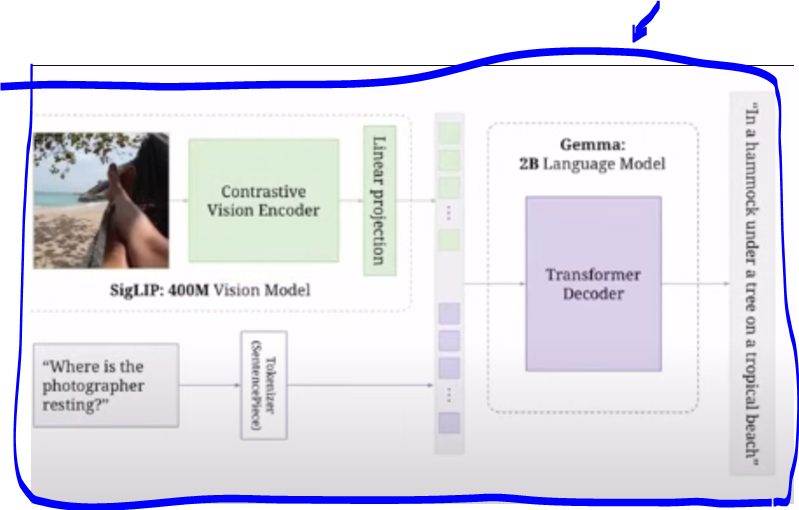

In [23]:
class PaliGemmaForConditionalGeneration(nn.Module):
    def __init__(self, config: PaliGemmaConfig):
        super().__init__()
        self.config = config
        self.vision_tower = SiglipVisionModel(config.vision_config)
        self.multi_modal_projector = PaliGemmaMultiModalProjector(config)
        self.vocab_size = config.vocab_size

        language_model = GemmaForCausalLM(config.text_config)
        self.language_model = language_model

        self.pad_token_id = self.config.pad_token_id if self.config.pad_token_id is not None else -1

    def tie_weights(self):
        return self.language_model.tie_weights()

    def _merge_input_ids_with_image_features(
        self, image_features: torch.Tensor, inputs_embeds: torch.Tensor, input_ids: torch.Tensor, attention_mask: torch.Tensor, kv_cache: Optional[KVCache] = None
    ):
        _, _, embed_dim = image_features.shape
        batch_size, sequence_length = input_ids.shape
        dtype, device = inputs_embeds.dtype, inputs_embeds.device
        # Shape: [Batch_Size, Seq_Len, Hidden_Size]
        scaled_image_features = image_features / (self.config.hidden_size**0.5)

        # Combine the embeddings of the image tokens, the text tokens and mask out all the padding tokens.
        final_embedding = torch.zeros(batch_size, sequence_length, embed_dim, dtype=inputs_embeds.dtype, device=inputs_embeds.device)
        # Shape: [Batch_Size, Seq_Len]. True for text tokens
        text_mask = (input_ids != self.config.image_token_index) & (input_ids != self.pad_token_id)
        # Shape: [Batch_Size, Seq_Len]. True for image tokens
        image_mask = input_ids == self.config.image_token_index
        # Shape: [Batch_Size, Seq_Len]. True for padding tokens
        pad_mask = input_ids == self.pad_token_id

        # We need to expand the masks to the embedding dimension otherwise we can't use them in torch.where
        text_mask_expanded = text_mask.unsqueeze(-1).expand(-1, -1, embed_dim)
        pad_mask_expanded = pad_mask.unsqueeze(-1).expand(-1, -1, embed_dim)
        image_mask_expanded = image_mask.unsqueeze(-1).expand(-1, -1, embed_dim)

        # Add the text embeddings
        final_embedding = torch.where(text_mask_expanded, inputs_embeds, final_embedding)
        # Insert image embeddings. We can't use torch.where because the sequence length of scaled_image_features is not equal to the sequence length of the final embedding
        final_embedding = final_embedding.masked_scatter(image_mask_expanded, scaled_image_features)
        # Zero out padding tokens
        final_embedding = torch.where(pad_mask_expanded, torch.zeros_like(final_embedding), final_embedding)

        #### CREATE THE ATTENTION MASK ####

        dtype, device = inputs_embeds.dtype, inputs_embeds.device
        min_dtype = torch.finfo(dtype).min
        q_len = inputs_embeds.shape[1]

        if kv_cache is None or kv_cache.num_items() == 0:
            # Do not mask any token, because we're in the prefill phase
            # This only works when we have no padding
            causal_mask = torch.full(
                (batch_size, q_len, q_len), fill_value=0, dtype=dtype, device=device
            )
        else:
            # Since we are generating tokens, the query must be one single token
            assert q_len == 1
            kv_len = kv_cache.num_items() + q_len
            # Also in this case we don't need to mask anything, since each query should be able to attend all previous tokens.
            # This only works when we have no padding
            causal_mask = torch.full(
                (batch_size, q_len, kv_len), fill_value=0, dtype=dtype, device=device
            )

        # Add the head dimension
        # [Batch_Size, Q_Len, KV_Len] -> [Batch_Size, Num_Heads_Q, Q_Len, KV_Len]
        causal_mask = causal_mask.unsqueeze(1)

        if kv_cache is not None and kv_cache.num_items() > 0:
            # The position of the query is just the last position
            position_ids = attention_mask.cumsum(-1)[:, -1]
            if position_ids.dim() == 1:
                position_ids = position_ids.unsqueeze(0)
        else:
            # Create a position_ids based on the size of the attention_mask
            # For masked tokens, use the number 1 as position.
            position_ids = (attention_mask.cumsum(-1)).masked_fill_((attention_mask == 0), 1).to(device)

        return final_embedding, causal_mask, position_ids

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        pixel_values: torch.FloatTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple:

        # Make sure the input is right-padded
        assert torch.all(attention_mask == 1), "The input cannot be padded"

        # 1. Extra the input embeddings
        # shape: (Batch_Size, Seq_Len, Hidden_Size)
        inputs_embeds = self.language_model.get_input_embeddings()(input_ids)

        # 2. Merge text and images
        # [Batch_Size, Channels, Height, Width] -> [Batch_Size, Num_Patches, Embed_Dim]
        selected_image_feature = self.vision_tower(pixel_values.to(inputs_embeds.dtype))
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Hidden_Size]
        image_features = self.multi_modal_projector(selected_image_feature)

        # Merge the embeddings of the text tokens and the image tokens
        inputs_embeds, attention_mask, position_ids = self._merge_input_ids_with_image_features(image_features, inputs_embeds, input_ids, attention_mask, kv_cache)

        outputs = self.language_model(
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            kv_cache=kv_cache,
        )

        return outputs

**PaliGemmaMultiModalProjector**

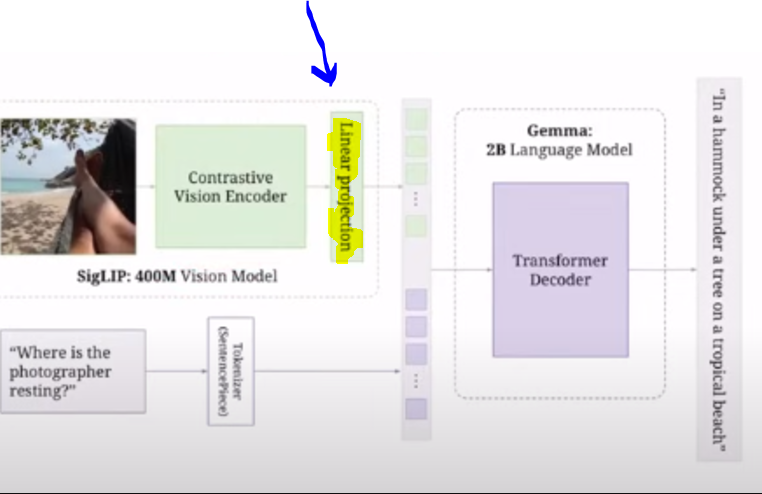

In [24]:
class PaliGemmaMultiModalProjector(nn.Module):
    def __init__(self, config: PaliGemmaConfig):
        super().__init__()
        self.linear = nn.Linear(config.vision_config.hidden_size, config.vision_config.projection_dim, bias=True)

    def forward(self, image_features):
        # [Batch_Size, Num_Patches, Embed_Dim] -> [Batch_Size, Num_Patches, Projection_Dim]
        hidden_states = self.linear(image_features)
        return hidden_states

**GemmaForCausalLM**

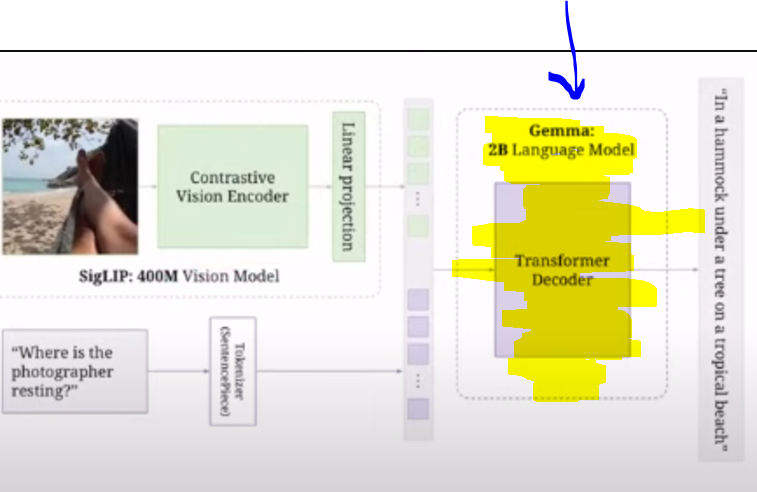

In [25]:
class GemmaForCausalLM(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = GemmaModel(config)
        self.vocab_size = config.vocab_size
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

    def get_input_embeddings(self):
        return self.model.embed_tokens

    def tie_weights(self):
        self.lm_head.weight = self.model.embed_tokens.weight

    def forward(
        self,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple:

        # input_embeds: [Batch_Size, Seq_Len, Hidden_Size]
        # outputs: [Batch_Size, Seq_Len, Hidden_Size]
        outputs = self.model(
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            kv_cache=kv_cache,
        )

        hidden_states = outputs
        logits = self.lm_head(hidden_states)
        logits = logits.float()

        return_data = {
            "logits": logits,
        }

        if kv_cache is not None:
            # Return the updated cache
            return_data["kv_cache"] = kv_cache

        return return_data

**Gemma Model**

In [26]:
class GemmaModel(nn.Module):

    def __init__(self, config: GemmaConfig):
        super().__init__()
        self.config = config
        self.padding_idx = config.pad_token_id
        self.vocab_size = config.vocab_size

        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size, self.padding_idx)
        self.layers = nn.ModuleList(
            [GemmaDecoderLayer(config, layer_idx) for layer_idx in range(config.num_hidden_layers)]
        )
        self.norm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def get_input_embeddings(self):
        return self.embed_tokens

    # Ignore copy
    def forward(
        self,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> torch.FloatTensor:
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = inputs_embeds
        # [Batch_Size, Seq_Len, Hidden_Size]
        normalizer = torch.tensor(self.config.hidden_size**0.5, dtype=hidden_states.dtype)
        hidden_states = hidden_states * normalizer

        for decoder_layer in self.layers:
            # [Batch_Size, Seq_Len, Hidden_Size]
            hidden_states = decoder_layer(
                hidden_states,
                attention_mask=attention_mask,
                position_ids=position_ids,
                kv_cache=kv_cache,
            )

        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.norm(hidden_states)

        # [Batch_Size, Seq_Len, Hidden_Size]
        return hidden_states

**Gemma Decoder Layer**

In [27]:
class GemmaDecoderLayer(nn.Module):

    def __init__(self, config: GemmaConfig, layer_idx: int):
        super().__init__()
        self.hidden_size = config.hidden_size

        self.self_attn = GemmaAttention(config=config, layer_idx=layer_idx)

        self.mlp = GemmaMLP(config)
        self.input_layernorm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.post_attention_layernorm = GemmaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        kv_cache: Optional[KVCache] = None,
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
        residual = hidden_states
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.input_layernorm(hidden_states)

        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states, _, = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            kv_cache=kv_cache,
        )
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = residual + hidden_states

        # [Batch_Size, Seq_Len, Hidden_Size]
        residual = hidden_states
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.post_attention_layernorm(hidden_states)
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = self.mlp(hidden_states)
        # [Batch_Size, Seq_Len, Hidden_Size]
        hidden_states = residual + hidden_states

        return hidden_states

**Gemma RMS Norm**

In [28]:
class GemmaRMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.zeros(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float())
        # Llama does x.to(float16) * w whilst Gemma is (x * w).to(float16)
        # See https://github.com/huggingface/transformers/pull/29402
        output = output * (1.0 + self.weight.float())
        return output.type_as(x)

**GemmaAttention**

In [29]:
class GemmaAttention(nn.Module):

    def __init__(self, config: GemmaConfig, layer_idx: Optional[int] = None):
        super().__init__()
        self.config = config
        self.layer_idx = layer_idx

        self.attention_dropout = config.attention_dropout
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = config.head_dim
        self.num_key_value_heads = config.num_key_value_heads
        self.num_key_value_groups = self.num_heads // self.num_key_value_heads
        self.max_position_embeddings = config.max_position_embeddings
        self.rope_theta = config.rope_theta
        self.is_causal = True

        assert self.hidden_size % self.num_heads == 0

        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=config.attention_bias)
        self.k_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=config.attention_bias)
        self.v_proj = nn.Linear(self.hidden_size, self.num_key_value_heads * self.head_dim, bias=config.attention_bias)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=config.attention_bias)
        self.rotary_emb = GemmaRotaryEmbedding(
            self.head_dim,
            max_position_embeddings=self.max_position_embeddings,
            base=self.rope_theta,
        )

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        kv_cache: Optional[KVCache] = None,
        **kwargs,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        bsz, q_len, _ = hidden_states.size() # [Batch_Size, Seq_Len, Hidden_Size]
        # [Batch_Size, Seq_Len, Num_Heads_Q * Head_Dim]
        query_states = self.q_proj(hidden_states)
        # [Batch_Size, Seq_Len, Num_Heads_KV * Head_Dim]
        key_states = self.k_proj(hidden_states)
        # [Batch_Size, Seq_Len, Num_Heads_KV * Head_Dim]
        value_states = self.v_proj(hidden_states)
        # [Batch_Size, Num_Heads_Q, Seq_Len, Head_Dim]
        query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        # [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
        key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
        # [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
        value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

        # [Batch_Size, Seq_Len, Head_Dim], [Batch_Size, Seq_Len, Head_Dim]
        cos, sin = self.rotary_emb(value_states, position_ids, seq_len=None)
        # [Batch_Size, Num_Heads_Q, Seq_Len, Head_Dim], [Batch_Size, Num_Heads_KV, Seq_Len, Head_Dim]
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if kv_cache is not None:
            key_states, value_states = kv_cache.update(key_states, value_states, self.layer_idx)

        # Repeat the key and values to match the number of heads of the query
        key_states = repeat_kv(key_states, self.num_key_value_groups)
        value_states = repeat_kv(value_states, self.num_key_value_groups)
        # Perform the calculation as usual, Q * K^T / sqrt(head_dim). Shape: [Batch_Size, Num_Heads_Q, Seq_Len_Q, Seq_Len_KV]
        attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(self.head_dim)

        assert attention_mask is not None
        attn_weights = attn_weights + attention_mask

        # Apply the softmax
        # [Batch_Size, Num_Heads_Q, Seq_Len_Q, Seq_Len_KV]
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)
        # Apply the dropout
        attn_weights = nn.functional.dropout(attn_weights, p=self.attention_dropout, training=self.training)
        # Multiply by the values. [Batch_Size, Num_Heads_Q, Seq_Len_Q, Seq_Len_KV] x [Batch_Size, Num_Heads_KV, Seq_Len_KV, Head_Dim] -> [Batch_Size, Num_Heads_Q, Seq_Len_Q, Head_Dim]
        attn_output = torch.matmul(attn_weights, value_states)

        if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )
        # Make sure the sequence length is the second dimension. # [Batch_Size, Num_Heads_Q, Seq_Len_Q, Head_Dim] -> [Batch_Size, Seq_Len_Q, Num_Heads_Q, Head_Dim]
        attn_output = attn_output.transpose(1, 2).contiguous()
        # Concatenate all the heads together. [Batch_Size, Seq_Len_Q, Num_Heads_Q, Head_Dim] -> [Batch_Size, Seq_Len_Q, Num_Heads_Q * Head_Dim]
        attn_output = attn_output.view(bsz, q_len, -1)
        # Multiply by W_o. [Batch_Size, Seq_Len_Q, Hidden_Size]
        attn_output = self.o_proj(attn_output)

        return attn_output, attn_weights

**GemmaRotaryEmbedding**

In [30]:
class GemmaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim # it is set to the head_dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base

        # Calculate the theta according to the formula theta_i = base^(2i/dim) where i = 0, 1, 2, ..., dim // 2
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim))
        self.register_buffer("inv_freq", tensor=inv_freq, persistent=False)

    @torch.no_grad()
    def forward(self, x, position_ids, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        self.inv_freq.to(x.device)
        # Copy the inv_freq tensor for batch in the sequence
        # inv_freq_expanded: [Batch_Size, Head_Dim // 2, 1]
        inv_freq_expanded = self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        # position_ids_expanded: [Batch_Size, 1, Seq_Len]
        position_ids_expanded = position_ids[:, None, :].float()
        device_type = x.device.type
        device_type = device_type if isinstance(device_type, str) and device_type != "mps" else "cpu"
        with torch.autocast(device_type=device_type, enabled=False):
            # Multiply each theta by the position (which is the argument of the sin and cos functions)
            # freqs: [Batch_Size, Head_Dim // 2, 1] @ [Batch_Size, 1, Seq_Len] --> [Batch_Size, Seq_Len, Head_Dim // 2]
            freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
            # emb: [Batch_Size, Seq_Len, Head_Dim]
            emb = torch.cat((freqs, freqs), dim=-1)
            # cos, sin: [Batch_Size, Seq_Len, Head_Dim]
            cos = emb.cos()
            sin = emb.sin()
        return cos.to(dtype=x.dtype), sin.to(dtype=x.dtype)

In [31]:
def rotate_half(x):
    # Build the [-x2, x1, -x4, x3, ...] tensor for the sin part of the positional encoding.
    x1 = x[..., : x.shape[-1] // 2] # Takes the first half of the last dimension
    x2 = x[..., x.shape[-1] // 2 :] # Takes the second half of the last dimension
    return torch.cat((-x2, x1), dim=-1)

In [32]:
def apply_rotary_pos_emb(q, k, cos, sin, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim) # Add the head dimension
    sin = sin.unsqueeze(unsqueeze_dim) # Add the head dimension
    # Apply the formula (34) of the Rotary Positional Encoding paper.
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

**Gemma MLP**

In [33]:
class GemmaMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)

    def forward(self, x):
        # Equivalent to:
        # y = self.gate_proj(x) # [Batch_Size, Seq_Len, Hidden_Size] -> [Batch_Size, Seq_Len, Intermediate_Size]
        # y = torch.gelu(y, approximate="tanh") # [Batch_Size, Seq_Len, Intermediate_Size]
        # j = self.up_proj(x) # [Batch_Size, Seq_Len, Hidden_Size] -> [Batch_Size, Seq_Len, Intermediate_Size]
        # z = y * j # [Batch_Size, Seq_Len, Intermediate_Size]
        # z = self.down_proj(z) # [Batch_Size, Seq_Len, Intermediate_Size] -> [Batch_Size, Seq_Len, Hidden_Size]
        return self.down_proj(nn.functional.gelu(self.gate_proj(x), approximate="tanh") * self.up_proj(x))

# **4  Loading....**

**Note** Ensure you also upload your image file to Colab, e.g., /content/test_images/pic1.jpeg.


Go to this link https://huggingface.co/google/paligemma-3b-pt-224/tree/main

clone this

after cloning you will get safetensors files and config also some other files ,just load them with under code,simple

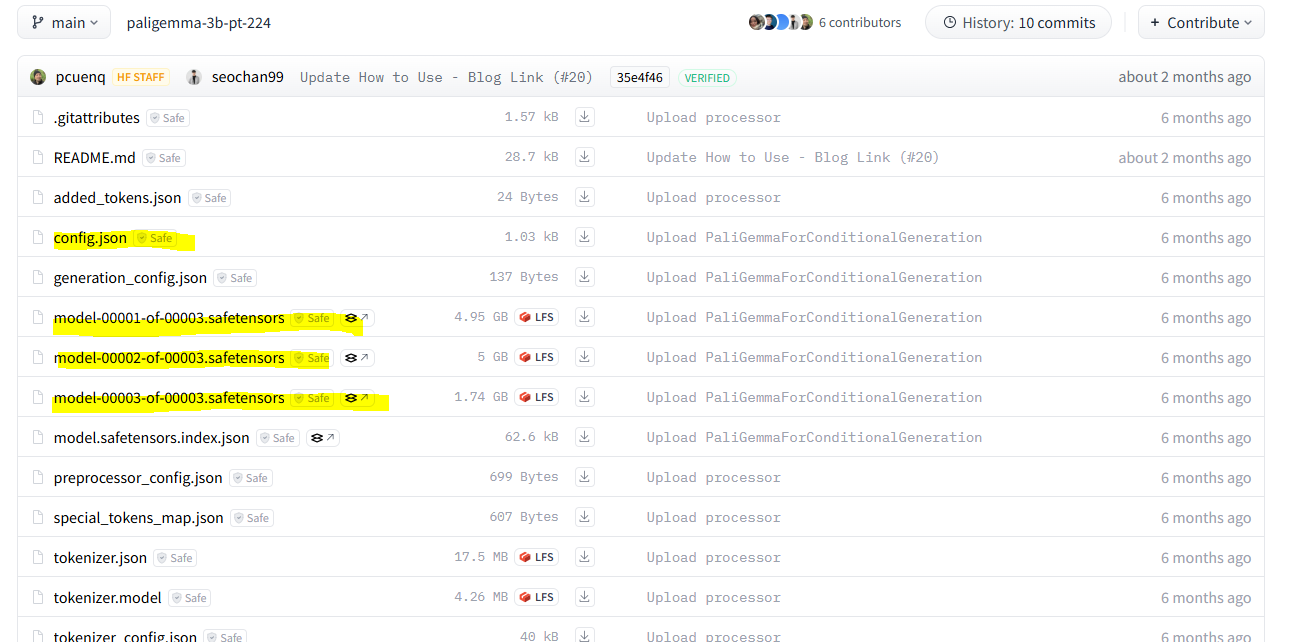

**use this extra code to for clone**

In [42]:
!pip install transformers huggingface_hub

In [43]:
from huggingface_hub import login

login("your_huggingface_token")

Get your token from Hugging Face.

In [44]:
from huggingface_hub import snapshot_download

# Clone the model
model_path = snapshot_download(repo_id="google/paligemma-3b-pt-224", local_dir="/content/paligemma-weights")
print(f"Model downloaded to: {model_path}")


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

Model downloaded to: /content/paligemma-weights


In [ ]:
!ls /content/paligemma-weights

In [60]:
PROMPT="this building is "
IMAGE_FILE_PATH="test_images/pic1.jpeg"
MAX_TOKENS_TO_GENERATE=100
TEMPERATURE=0.8
TOP_P=0.9
DO_SAMPLE="False"
ONLY_CPU="False"

In [61]:
def load_hf_model(model_path: str, device: str) -> Tuple[PaliGemmaForConditionalGeneration, AutoTokenizer]:
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side="right")
    assert tokenizer.padding_side == "right"

    # Find all the *.safetensors files
    safetensors_files = glob.glob(os.path.join(model_path, "*.safetensors"))

    # ... and load them one by one in the tensors dictionary
    tensors = {}
    for safetensors_file in safetensors_files:
        with safe_open(safetensors_file, framework="pt", device="cpu") as f:
            for key in f.keys():
                tensors[key] = f.get_tensor(key)

    # Load the model's config
    with open(os.path.join(model_path, "config.json"), "r") as f:
        model_config_file = json.load(f)
        config = PaliGemmaConfig(**model_config_file)

    # Create the model using the configuration
    model = PaliGemmaForConditionalGeneration(config).to(device)

    # Load the state dict of the model
    model.load_state_dict(tensors, strict=False)

    # Tie weights
    model.tie_weights()

    return (model, tokenizer)

# **5 Inference**

In [62]:
def move_inputs_to_device(model_inputs: dict, device: str):
    model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
    return model_inputs

In [63]:
def get_model_inputs(
    processor: PaliGemmaProcessor, prompt: str, image_file_path: str, device: str
):
    image = Image.open(image_file_path)
    images = [image]
    prompts = [prompt]
    model_inputs = processor(text=prompts, images=images)
    model_inputs = move_inputs_to_device(model_inputs, device)
    return model_inputs

In [64]:
def test_inference(
    model: PaliGemmaForConditionalGeneration,
    processor: PaliGemmaProcessor,
    device: str,
    prompt: str,
    image_file_path: str,
    max_tokens_to_generate: int,
    temperature: float,
    top_p: float,
    do_sample: bool,
):
    model_inputs = get_model_inputs(processor, prompt, image_file_path, device)
    input_ids = model_inputs["input_ids"]
    attention_mask = model_inputs["attention_mask"]
    pixel_values = model_inputs["pixel_values"]

    kv_cache = KVCache()

    # Generate tokens until you see the stop token
    stop_token = processor.tokenizer.eos_token_id
    generated_tokens = []

    for _ in range(max_tokens_to_generate):
        # Get the model outputs
        # TODO: remove the labels
        outputs = model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            kv_cache=kv_cache,
        )
        kv_cache = outputs["kv_cache"]
        next_token_logits = outputs["logits"][:, -1, :]
        # Sample the next token
        if do_sample:
            # Apply temperature
            next_token_logits = torch.softmax(next_token_logits / temperature, dim=-1)
            next_token = _sample_top_p(next_token_logits, top_p)
        else:
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        assert next_token.size() == (1, 1)
        next_token = next_token.squeeze(0)  # Remove batch dimension
        generated_tokens.append(next_token)
        # Stop if the stop token has been generated
        if next_token.item() == stop_token:
            break
        # Append the next token to the input
        input_ids = next_token.unsqueeze(-1)
        attention_mask = torch.cat(
            [attention_mask, torch.ones((1, 1), device=input_ids.device)], dim=-1
        )

    generated_tokens = torch.cat(generated_tokens, dim=-1)
    # Decode the generated tokens
    decoded = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    print(prompt + decoded)


In [65]:
def _sample_top_p(probs: torch.Tensor, p: float):
    # (B, vocab_size)
    probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
    # (B, vocab_size)
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    # (B, vocab_size)
    # (Substracting "probs_sort" shifts the cumulative sum by 1 position to the right before masking)
    mask = probs_sum - probs_sort > p
    # Zero out all the probabilities of tokens that are not selected by the Top P
    probs_sort[mask] = 0.0
    # Redistribute the probabilities so that they sum up to 1.
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    # Sample a token (its index) from the top p distribution
    next_token = torch.multinomial(probs_sort, num_samples=1)
    # Get the token position in the vocabulary corresponding to the sampled index
    next_token = torch.gather(probs_idx, -1, next_token)
    return next_token


In [66]:
def main(
    model_path: str = None,
    prompt: str = None,
    image_file_path: str = None,
    max_tokens_to_generate: int = 100,
    temperature: float = 0.8,
    top_p: float = 0.9,
    do_sample: bool = False,
    only_cpu: bool = False,
):
    device = "cpu"

    if not only_cpu:
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"

    print("Device in use: ", device)

    print(f"Loading model")
    model, tokenizer = load_hf_model(model_path, device)
    model = model.to(device).eval()

    num_image_tokens = model.config.vision_config.num_image_tokens
    image_size = model.config.vision_config.image_size
    processor = PaliGemmaProcessor(tokenizer, num_image_tokens, image_size)

    print("Running inference")
    with torch.no_grad():
        test_inference(
            model,
            processor,
            device,
            prompt,
            image_file_path,
            max_tokens_to_generate,
            temperature,
            top_p,
            do_sample,
        )


In [ ]:
if __name__ == "__main__":
    fire.Fire(main)